In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import os
import pandas as pd
import torch
from dataset_preprocessing import TokenInfo
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import itertools
import pandas as pd
from tqdm import tqdm

## Importances

In [4]:
def get_importances():
    # print("this is wrong")
    dir = "./new_importances_data"
    imp_files = os.listdir(dir)
    imp_files = [file for file in imp_files if file.endswith(".pkl")]
    importances = {}
    for imp_file in tqdm(imp_files):
        importances.update(pd.read_pickle(f"{dir}/{imp_file}"))
    return importances

In [5]:
# imps = get_importances()

In [6]:
def get_avg_imporances(importances):
    avg_imps = [torch.zeros_like(imp) for imp in list(importances.values())[0]]
    for token, imps in tqdm(importances.items()):
        for i, layer_imps in enumerate(imps):
            avg_imps[i] += layer_imps / len(importances)
    # TODO think harder about averaging method
    return avg_imps

In [7]:
# avg_importances = get_avg_imporances(imps)

In [8]:
# pd.to_pickle(avg_importances, "./avg_importances.pkl")

In [9]:
avg_importances = pd.read_pickle("./avg_importances.pkl")

In [10]:
len(avg_importances)

24

## Model

In [11]:
model_id = "microsoft/phi-1_5"
model_revision = "349cf8b5e81fd5f791d1740da5de1313a0419bbd" # latest as of feb 1st

In [12]:
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

In [13]:
vocab = tokenizer.get_vocab()
len(vocab)

50295

In [14]:
# tokenizer.decode(token_info.get_prefixes(top_tokens[1000][0], 9, 10)[0])

In [15]:
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    revision=model_revision,
    trust_remote_code=True,
    # be careful with this?
    # torch_dtype=torch.float16,
    # attn_implementation="flash_attention_2",
)

## Prune Model

In [16]:
from prunners import prune_mlps_individually
from importances import get_mlps

In [17]:
mlps = get_mlps(model)

In [18]:
len(mlps), len(avg_importances)

(24, 24)

In [19]:
avg_importances = dict(zip(mlps, avg_importances))

In [20]:
prune_mlps_individually(avg_importances, 0.5)

In [21]:
model

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2048)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-23): 24 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2048, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=2048, bias=True)
        )
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((2048,), e

## New Dataset

In [22]:
from other_datasets import get_minipile, get_c4, get_wikitext2_filtered, get_bookcorpus, get_alpaca, QADataCollator, to_dataset
from dataset import get_baseline_dataset

/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


In [23]:
alpaca_train, alpaca_eval = get_alpaca(tokenizer, do_split=True)
# eval datasets
# tiny_text = get_baseline_dataset()["test"]
# c4 = get_c4(n=2000, do_split=False)
minipile = get_minipile(n=2000, do_split=False)
wikitext = get_wikitext2_filtered(n=2000, do_split=False)
bookcorpus = get_bookcorpus(n=2000, do_split=False)

2024-03-05 00:57:16.361 | INFO     | other_datasets:__init__:309 - Mean length of tokens per window: 111.64232
2024-03-05 00:57:17.377 | INFO     | other_datasets:__init__:309 - Mean length of tokens per window: 109.2675


## Metric Callback

In [24]:
from transformers import TrainerCallback

In [25]:
from evaluation import evaluate_on_nlp_tasks

In [26]:
class AccEvalCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.last_step=-1
    
    def on_evaluate(self, args, state, control, model, **kwargs):
        if state.global_step == self.last_step:
            return
        self.last_step = state.global_step
        train = model.training
        model.eval()
        with torch.no_grad():
            os.environ["TQDM_DISABLE"] = "1"
            eval_res = evaluate_on_nlp_tasks(model, tokenizer, limit=1000)["results"]
            # import pdb; pdb.set_trace()
            eval_res = {k:v["acc,none"] for k,v in eval_res.items()}
            for k, v in eval_res.items():
                state.log_history.append(
                    {
                        k:v,
                        "epoch":state.epoch,
                        "step":state.global_step,
                    }
                )
            del os.environ['TQDM_DISABLE']
            print(eval_res)
        model.train(train)

## Train model

In [27]:
from peft import LoraConfig, PeftConfig
import transformers

In [28]:
from post_training import get_lora_config, get_training_arguments
from other_datasets import SFTTrainer_
from trl import SFTTrainer

In [29]:
lora_config = get_lora_config()
training_arguments = get_training_arguments("./tmp")

In [30]:
model.cuda();

In [31]:
model.config.use_cache = False
model.config.pretraining_tp = 1
model.gradient_checkpointing_enable()

In [33]:
# train_data, eval_data = minipile["train"], minipile["test"]
train_data, eval_data = alpaca_train, alpaca_eval
eval_datasets = {
    "alpaca":alpaca_eval,
    "minipile":minipile,
    # "c4":c4,
    "wikitext":wikitext,
    # "tiny_text":tiny_text,
    "bookcorpus":bookcorpus,
}

In [34]:
callbacks = [AccEvalCallback()]

In [35]:
tokenizer.pad_token = tokenizer.eos_token

In [36]:
training_arguments.save_strategy="no"

In [37]:
training_arguments.eval_steps = 100

In [38]:
trainer = SFTTrainer_(
    model=model,
    train_dataset=train_data,
    eval_dataset=eval_datasets,
    # eval_dataset={k:v.select(range(0, 100)) for k, v in eval_datasets.items()},
    # eval_dataset=eval_datasets["minipile"],
    peft_config=lora_config,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=False,
    dataset_text_field="text",
    max_seq_length=1024, # tweak this
    # TODO: think harder about the datacollator
    # data_collator=transformers.DataCollatorForSeq2Seq(
    #     tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True
    # ),
    callbacks=callbacks,
    data_collator=QADataCollator(tokenizer),
)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

2024-03-05:00:58:58,041 WARNING  [logging.py:61] Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [ ]:
model.eval();
with torch.no_grad():
    eval_res = evaluate_on_nlp_tasks(model, tokenizer, limit=1000)
model.train()

In [85]:
eval_res["results"]

{'hellaswag': {'acc,none': 0.348,
  'acc_norm,none': 0.443,
  'alias': 'hellaswag'},
 'piqa': {'acc,none': 0.671, 'acc_norm,none': 0.665, 'alias': 'piqa'},
 'boolq': {'acc,none': 0.625, 'alias': 'boolq'},
 'winogrande': {'acc,none': 0.522, 'alias': 'winogrande'}}

In [39]:
train_res = trainer.train()

Step,Training Loss,Validation Loss,Alpaca Loss,Minipile Loss,Wikitext Loss,Bookcorpus Loss
100,2.062100,No log,2.059247,3.300472,4.612859,6.476511
200,1.858400,No log,1.862062,3.134349,4.442205,6.385263
300,1.768100,No log,1.813145,3.095857,4.401748,6.330591
400,1.736800,No log,1.786781,3.074493,4.376541,6.289120
500,1.782100,No log,1.770721,3.058629,4.348290,6.250180
600,1.739200,No log,1.761202,3.050407,4.331659,6.236434
700,1.780800,No log,1.752143,3.039371,4.323121,6.216656
800,1.711500,No log,1.745654,3.036259,4.323344,6.218310
900,1.731400,No log,1.741604,3.031970,4.312964,6.205688
1000,1.723500,No log,1.738209,3.030818,4.305368,6.199760


2024-03-05:01:05:25,087 WARNING  [huggingface.py:105] `pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
2024-03-05:01:05:25,104 WARNING  [huggingface.py:315] Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for winogrande contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/winogrande
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
/home/research/robgarct/.conda/envs/cs224n-pip3/lib

{'hellaswag': 0.37, 'piqa': 0.703, 'boolq': 0.625, 'winogrande': 0.566}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
You're using a CodeGenTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████████████████| 10000/10000 [06:55<00:00, 24.08it/s]


{'hellaswag': 0.389, 'piqa': 0.712, 'boolq': 0.631, 'winogrande': 0.567}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████████████████| 10000/10000 [06:41<00:00, 24.90it/s]


{'hellaswag': 0.395, 'piqa': 0.715, 'boolq': 0.632, 'winogrande': 0.574}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████████████████| 10000/10000 [05:23<00:00, 30.88it/s]


{'hellaswag': 0.395, 'piqa': 0.723, 'boolq': 0.632, 'winogrande': 0.591}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████████████████| 10000/10000 [05:21<00:00, 31.06it/s]


{'hellaswag': 0.394, 'piqa': 0.72, 'boolq': 0.631, 'winogrande': 0.595}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████████████████| 10000/10000 [05:21<00:00, 31.09it/s]


{'hellaswag': 0.388, 'piqa': 0.722, 'boolq': 0.633, 'winogrande': 0.598}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████████████████| 10000/10000 [05:21<00:00, 31.06it/s]


{'hellaswag': 0.394, 'piqa': 0.711, 'boolq': 0.634, 'winogrande': 0.595}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████████████████| 10000/10000 [05:21<00:00, 31.07it/s]


{'hellaswag': 0.392, 'piqa': 0.709, 'boolq': 0.635, 'winogrande': 0.586}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████████████████| 10000/10000 [05:21<00:00, 31.09it/s]


{'hellaswag': 0.391, 'piqa': 0.714, 'boolq': 0.632, 'winogrande': 0.594}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████████████████| 10000/10000 [05:21<00:00, 31.09it/s]


{'hellaswag': 0.389, 'piqa': 0.711, 'boolq': 0.632, 'winogrande': 0.596}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████████████████| 10000/10000 [05:21<00:00, 31.07it/s]


{'hellaswag': 0.391, 'piqa': 0.715, 'boolq': 0.633, 'winogrande': 0.598}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████████████████| 10000/10000 [05:21<00:00, 31.07it/s]


{'hellaswag': 0.39, 'piqa': 0.715, 'boolq': 0.631, 'winogrande': 0.591}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████████████████| 10000/10000 [05:22<00:00, 31.05it/s]


{'hellaswag': 0.388, 'piqa': 0.714, 'boolq': 0.63, 'winogrande': 0.592}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for winogrande contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/winogrande
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the 

{'hellaswag': 0.392, 'piqa': 0.716, 'boolq': 0.632, 'winogrande': 0.591}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████████████████| 10000/10000 [05:21<00:00, 31.07it/s]


{'hellaswag': 0.391, 'piqa': 0.712, 'boolq': 0.632, 'winogrande': 0.593}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████████████████| 10000/10000 [05:22<00:00, 31.06it/s]


{'hellaswag': 0.395, 'piqa': 0.713, 'boolq': 0.634, 'winogrande': 0.593}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [40]:
pd.to_pickle(trainer.state, "./tmp/alpaca_trainer_state_llm_pruner_style_0.5ratio.pkl")

In [41]:
trainer_state = trainer.state
pd.DataFrame(trainer_state.log_history).tail()

,loss,learning_rate,epoch,step,eval_alpaca_loss,eval_alpaca_runtime,eval_alpaca_samples_per_second,eval_alpaca_steps_per_second,hellaswag,piqa,...,eval_wikitext_steps_per_second,eval_bookcorpus_loss,eval_bookcorpus_runtime,eval_bookcorpus_samples_per_second,eval_bookcorpus_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
291,1.7008,2.298851e-06,1.96,1630,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
292,1.6857,1.660281e-06,1.97,1640,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
293,1.6942,1.021711e-06,1.98,1650,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
294,1.6982,3.831418e-07,1.99,1660,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
295,NaN,NaN,2.00,1666,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17256.4465,5.795,0.097,1.048783e+17,1.79244


### Evaluation

In [42]:
from evaluation import evaluate_on_nlp_tasks

In [43]:
model.eval();

In [44]:
with torch.no_grad():
    eval_res = evaluate_on_nlp_tasks(model, tokenizer, limit=300)

/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|███████████████████████████████████████| 3000/3000 [01:20<00:00, 37.27it/s]
fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [45]:
eval_res["results"]

{'hellaswag': {'acc,none': 0.4033333333333333,
  'acc_norm,none': 0.45,
  'alias': 'hellaswag'},
 'piqa': {'acc,none': 0.7, 'acc_norm,none': 0.72, 'alias': 'piqa'},
 'boolq': {'acc,none': 0.6333333333333333, 'alias': 'boolq'},
 'winogrande': {'acc,none': 0.6, 'alias': 'winogrande'}}

In [46]:
eval_res = evaluate_on_nlp_tasks(model, tokenizer, limit=1000)

/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████████████████| 10000/10000 [04:28<00:00, 37.18it/s]
fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [47]:
eval_res["results"]

{'hellaswag': {'acc,none': 0.394,
  'acc_norm,none': 0.484,
  'alias': 'hellaswag'},
 'piqa': {'acc,none': 0.716, 'acc_norm,none': 0.709, 'alias': 'piqa'},
 'boolq': {'acc,none': 0.633, 'alias': 'boolq'},
 'winogrande': {'acc,none': 0.593, 'alias': 'winogrande'}}

## Save

In [48]:
model.cpu();

In [49]:
torch.save(model.state_dict(), "./tmp/alpaca_model_llm_prunner_style_0.5ratio_state_dict")

## Looking at stats

In [51]:
df = pd.DataFrame(trainer_state.log_history)

In [52]:
metrics_df = df[["step", "hellaswag", "piqa", "boolq", "winogrande"]]

<Axes: xlabel='step'>

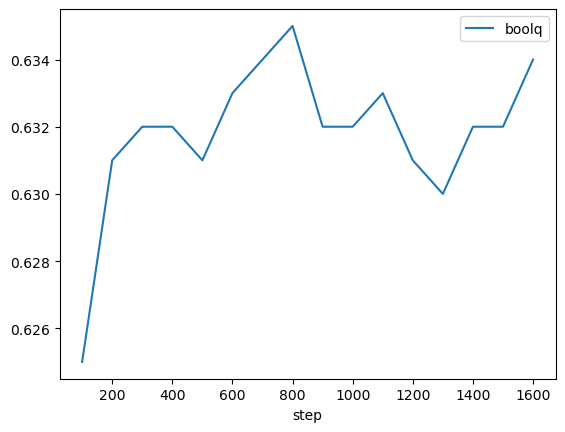

In [53]:
metrics_df[["step", "boolq"]].dropna().set_index("step").plot()

<Axes: xlabel='step'>

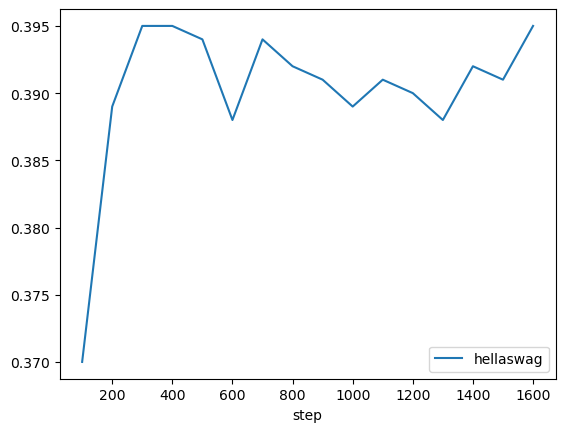

In [54]:
metrics_df[["step", "hellaswag"]].dropna().set_index("step").plot()

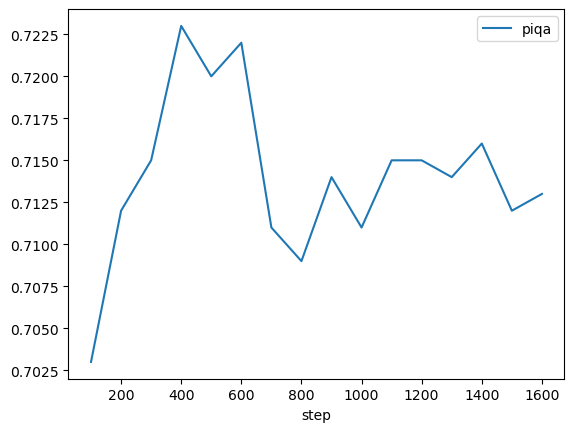

In [55]:
metrics_df = df[["step", "piqa"]].dropna().set_index("step").plot()

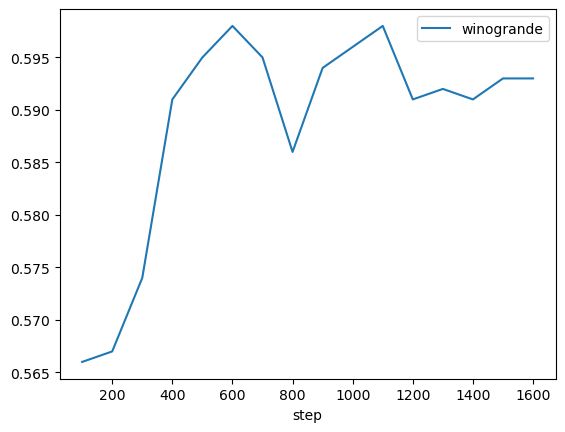

In [56]:
metrics_df = df[["step", "winogrande"]].dropna().set_index("step").plot()

In [96]:
eval_df = df[["step", "eval_alpaca_loss", "eval_wikitext_loss", "eval_bookcorpus_loss", "eval_minipile_loss"]].set_index("step")

<Axes: xlabel='step'>

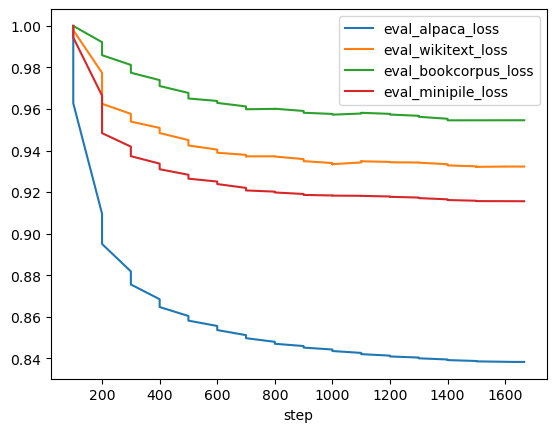

In [97]:
(eval_df / eval_df.max()).interpolate(method='linear').plot()

<Axes: xlabel='step'>

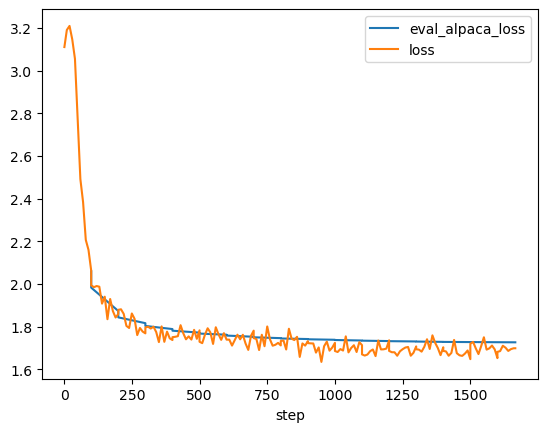

In [99]:
df[["step", "eval_alpaca_loss", "loss"]].set_index("step").interpolate(method='linear').plot()